# DS5110 Final Project, Dec 2025
By Brandon G. Villatla Lopez & Rachita Sharma

For the Maine Trust for Local News (METLN)

## Data Analysis Code

In this notebook we'll be reading the .csv file we created with the clean METLN data.

We'll also read the MainePop.csv file with population data.

We will use these to perform a relatively simple market analysis based on this 2024 subscriber data.

In [1]:
# in case you don't have the packages required, run this:
# !pip install -r requirements.txt

# or only install whatever specific package you need

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # for colormap control (only used in treemap)
import squarify # treemap algorithm: https://github.com/laserson/squarify

plt.style.use('ggplot')

### Read the data

In [3]:
all_data = pd.read_csv('METLN_Data/clean_data.csv')
all_data.head()

,Publication,AccountID,Status,Month,Online,City,State,Zip,OccupantID
0,AMG_TR,2389901,Active,2,False,Ringwood,NJ,07456,1917706
1,AMG_TR,2389906,Active,2,False,Austin,TX,78732,1917711
2,AMG_TR,2395490,Active,2,False,Medford,NJ,08055,1922411
3,AMG_TR,2432361,Active,2,False,Jasper,TN,37347,1955588
4,AMG_TR,2460639,Active,2,False,Campbell Hall,NY,10916,1980162


### A quick look at the overall trend
We're not really interested in "global" trends. Only really interested in Maine. But it might be nice to have a quick look if you want!

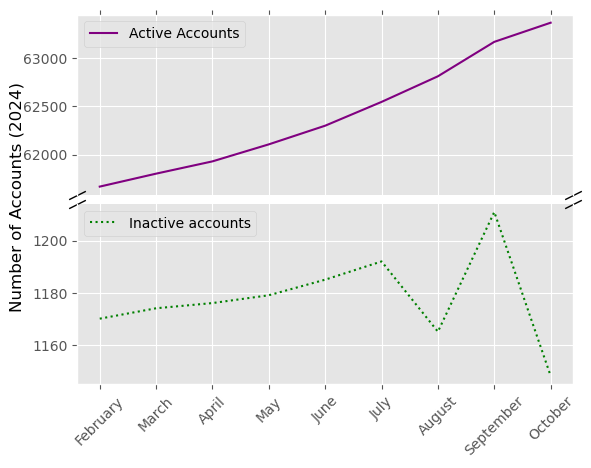

In [4]:
# let's split between active and inactive accounts and aggregate (count) by month
active_mask = all_data['Status'] == 'Active'
active_acs = all_data[active_mask].groupby('Month').count()['AccountID']
inactive_acs = all_data[~active_mask].groupby('Month').count()['AccountID']

# make a list of months for xlabels (it'll be useful later, too!)
months = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']

# creat the figure
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

ax1.plot(months, active_acs.to_numpy(), label='Active Accounts', c='purple') # plot active accounts
ax2.plot(months, inactive_acs.to_numpy(), label='Inactive accounts', c='green', ls=':') # plot inactive accounts

# THE CODE BELOW IS COPIED FROM: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the Axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the Axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# # rotate x_axis label
ax2.tick_params(axis='x',labelrotation=45)

ax1.legend()
ax2.legend()
fig.supylabel('Number of Accounts (2024)')
# fig.savefig(..., dpi=300) # save if you want!
plt.show()

#### a not very useful tangent...
we're not *very* interested in inactive accounts right now, but it has weird oscilations in the last few months so we wanted to have a closer look. The way we went about finding out what the sudden changes are is not very rigurous and it just gives a vague idea of what *might* have caused them.

In [5]:
# look at common accounts between July and August that have different 'Status'
df = pd.merge(all_data[all_data.Month==7],all_data[all_data.Month==8],on='AccountID',suffixes=['_Jul','_Aug'])
diff_df = df[~ (df.Status_Jul == df.Status_Aug)][['AccountID','Status_Jul','Status_Aug']]
print(diff_df.groupby('Status_Jul').count().AccountID)
print(diff_df.groupby('Status_Aug').count().AccountID)

Status_Jul
Active              8
In Grace Period    36
Name: AccountID, dtype: int64
Status_Aug
Active             36
In Grace Period     8
Name: AccountID, dtype: int64


This suggests the Jul --> Aug decrease in inactive accounts might be due to 'reactivated' accounts who had missed a payment and thus were previously listed as being "in grace period"

In [6]:
# do the same for August and September
df = pd.merge(all_data[all_data.Month==8],all_data[all_data.Month==9],on='AccountID',suffixes=['_Aug','_Sep'])
diff_df = df[~ (df.Status_Aug == df.Status_Sep)][['AccountID', 'Status_Aug', 'Status_Sep']]
print(diff_df.groupby('Status_Aug').count().AccountID)
print(diff_df.groupby('Status_Sep').count().AccountID)

Series([], Name: AccountID, dtype: int64)
Series([], Name: AccountID, dtype: int64)


Aug --> Sep increase in inactive accounts seems to be "newly inactivated" accounts (because there's none in common that changed status)

In [7]:
# and same for September and October
df = pd.merge(all_data[all_data.Month==9],all_data[all_data.Month==10],on='AccountID',suffixes=['_Sep','_Oct'])
diff_df = df[~ (df.Status_Sep == df.Status_Oct)][['AccountID', 'Status_Sep', 'Status_Oct']]
print(diff_df.groupby('Status_Sep').count().AccountID)
print(diff_df.groupby('Status_Oct').count().AccountID)

Status_Sep
Active             871
In Grace Period    322
On Vac Pack         18
Vac - Online       118
Name: AccountID, dtype: int64
Status_Oct
Active             457
In Grace Period    742
On Vac Pack         20
Vac - Online       110
Name: AccountID, dtype: int64


Sep --> Oct decrease in inactive accounts seems to be a mixture but there's actually a loss of active accounts. Thus, most of the decrease in inactive acc's is most likely due to them being removed from the sheet.

### A quick look at out-of-state trends
We're also not really intersted in the trends outside of Maine, but we thought it would be fun to have an idea of where METLN has subscribers out of state. So we quickly look at the number of active accounts per state (excluding ME)

In [8]:
print(all_data.State.unique(), len(all_data.State.unique())) # which/how many "states"

['NJ' 'TX' 'TN' 'NY' 'ME' 'MA' 'WV' 'OK' 'CT' 'HI' 'FL' 'NC' 'MD' 'NH'
 'PA' 'VA' 'MN' 'DC' 'IN' 'WA' 'CA' 'WI' 'VT' 'SD' 'SC' 'MT' 'OR' 'AK'
 'AZ' 'GA' 'CO' 'IL' 'IA' 'MI' 'RI' 'KS' 'AL' 'MS' 'KY' 'ID' 'AR' 'DE'
 'OH' 'MO' 'NM' 'AA' 'MP' 'UT' 'LA' 'AP' 'ON' 'ND' 'NV' 'NE' 'WY' 'AE'
 'NL' 'PR'] 58


Pretty much all states. But also some non-US locations. As well as army bases. Wow!

In [9]:
# is there anyone with print subscriptions outside of maine?
active_mask = all_data['Status'] == 'Active'

active_df = all_data[active_mask]
online_df = active_df[active_df.Online]
physical_df = active_df[~active_df.Online]

print('Monthly out-of-state online accounts\n', online_df[online_df.State != 'ME'].groupby('Month').count()['AccountID'].rename('Number of Online Accounts'))
print('Monthly of out-of-state print accounts\n', physical_df[physical_df.State != 'ME'].groupby('Month').count()['AccountID'].rename('Number of Physical Accounts'))

Monthly out-of-state online accounts
 Month
2     4366
3     4396
4     4424
5     4458
6     4496
7     4556
8     4624
9     4740
10    4735
Name: Number of Online Accounts, dtype: int64
Monthly of out-of-state print accounts
 Month
2     51
3     51
4     51
5     52
6     55
7     56
8     58
9     58
10    59
Name: Number of Physical Accounts, dtype: int64


Very few... but some!

C:\Users\Brandon\AppData\Local\Temp\ipykernel_32572\4148148742.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


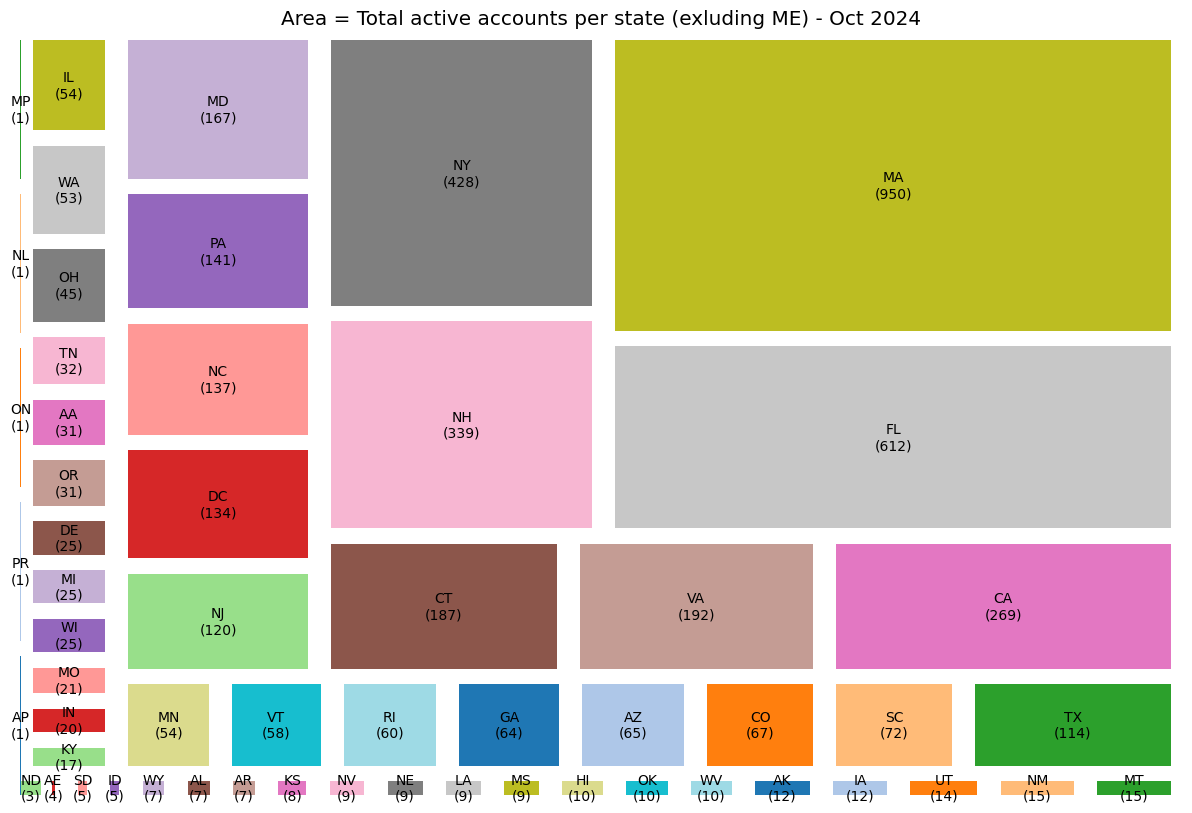

In [10]:
# Let's visualize the total active accounts per state with a treemap (better than a pie chart!!!)

# select and aggregate the data
state_counts_df = active_df[np.logical_and(active_df.Month == 10,active_df.State != 'ME')].groupby(['State','Online']).count().AccountID.unstack().rename(columns={False:'Print',True:'Online'})
state_counts_df['Total'] = state_counts_df.sum(axis=1)
state_counts_df = state_counts_df.sort_values(by='Total', ascending=True)

# and plot
cmap = cm.get_cmap('tab20')
state_codes, states = pd.factorize(state_counts_df.index)
colors = [cmap(code%20) for code in state_codes]
labels = state_counts_df.index+'\n('+state_counts_df.Total.astype(int).astype(str)+')' # add the total number to the label

fig, ax = plt.subplots(1,1,figsize=(15,10))

squarify.plot(sizes=state_counts_df.Total,
              label=labels,
              pad=True,
              color=colors)
plt.axis('off')
ax.set_title('Area = Total active accounts per state (exluding ME) - Oct 2024')
# fig.savefig(...,dpi=300) # save if you want!
plt.show()

#### another not very useful tangent...
Let me remind you that we're not interested in out-of-state trends, but here's some code to look at the subscription trends per state in case you're curious.

In [11]:
# Some places have months with 0 active accounts
# This messes up the data aggregation, so here's a fix
def fix_counts(series):
    '''
    This function will take any series with length <= 9 and indexes
    ranging from 2-10, and fill any wholes (e.g., no entry for ind 4)
    with zeros. I never expect to need this again so I hardcoded it :)
    '''
    zero = pd.Series(data=np.zeros(9),index=range(2,11),dtype=int)
    new = zero+series
    new[np.isnan(new)]=0
    new = new.astype(int)
    return new

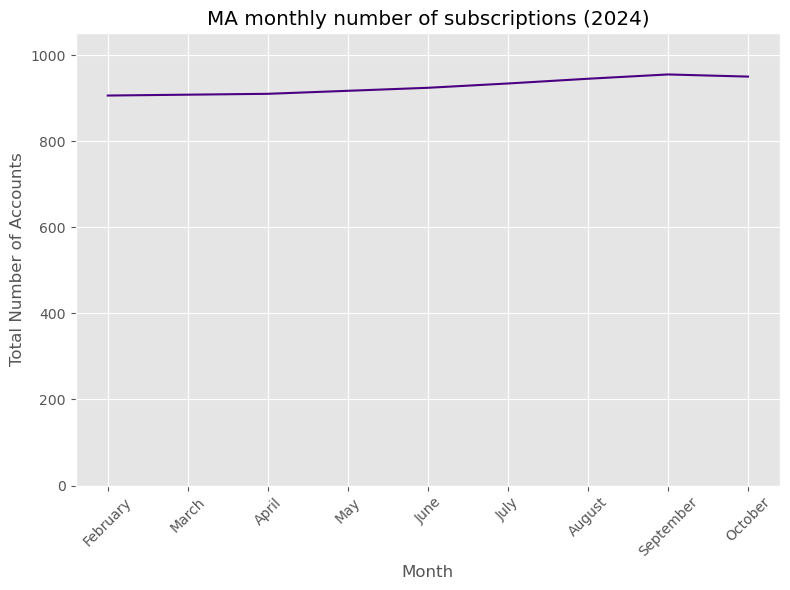

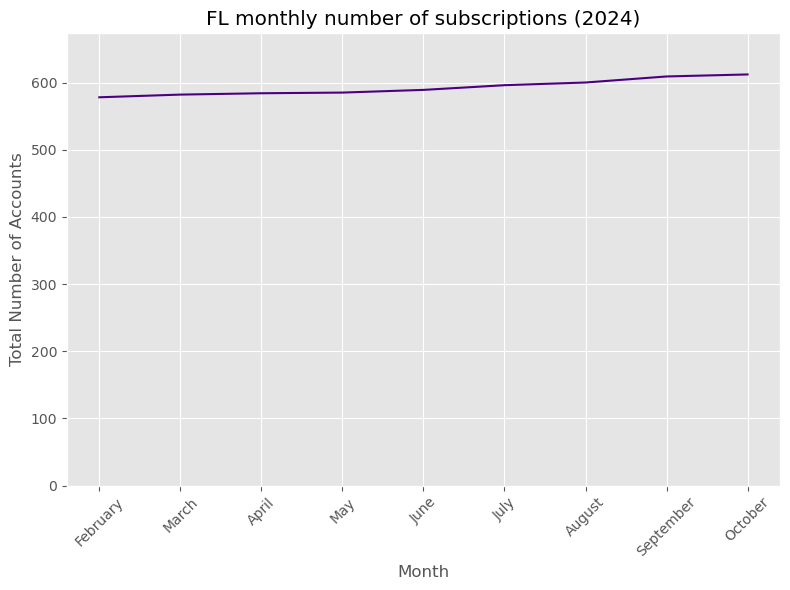

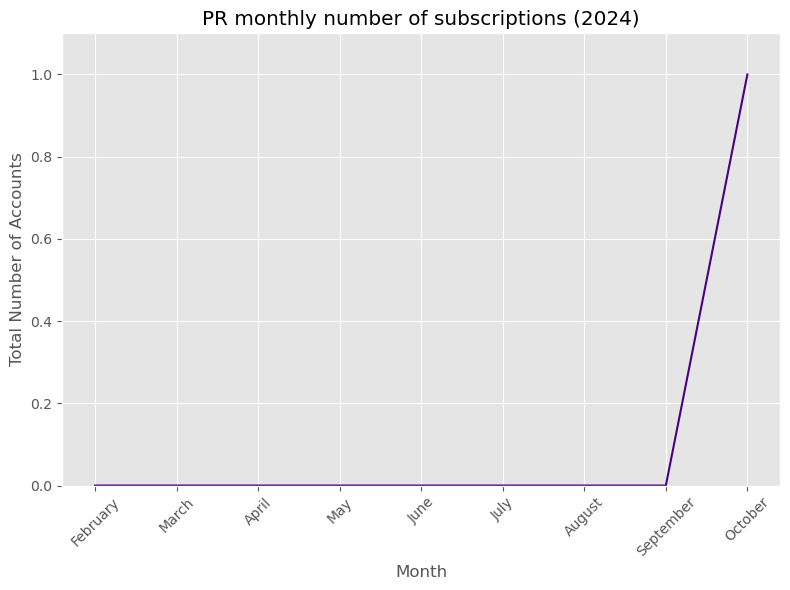

In [12]:
state_list = active_df.State.unique() # useful if we want to plot ALL (it's a lot)
states_to_plot = ['MA','FL','PR'] # chose one or many states to look at

months = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']

# for i, state in enumerate(state_list): # only run this if you want ALL (it's a lot)
for i, state in enumerate(states_to_plot):
    fig, ax = plt.subplots(figsize=(8,6))
    state_accs = fix_counts(active_df[active_df.State == state].groupby('Month').count()['AccountID'].rename('Total Accounts')).to_numpy()
    
    ax.plot(months,state_accs,c='indigo')

    # rotate x_axis label
    ax.tick_params(axis='x',labelrotation=45)

    # add title, axis etc
    ax.set(title = state+' monthly number of subscriptions (2024)', xlabel='Month', ylabel='Total Number of Accounts', ylim=(0,state_accs.max()+(.1*state_accs.max())))

    plt.tight_layout()
    # fig.savefig(...,dpi=300) #save if you want! (not reccomended!) - but DO make sure to use the i or state vars in the filename
    plt.show()

This was as useless as expected. But fun. Shoutout to that one Puerto Rican who subscribed in Oct 2024!

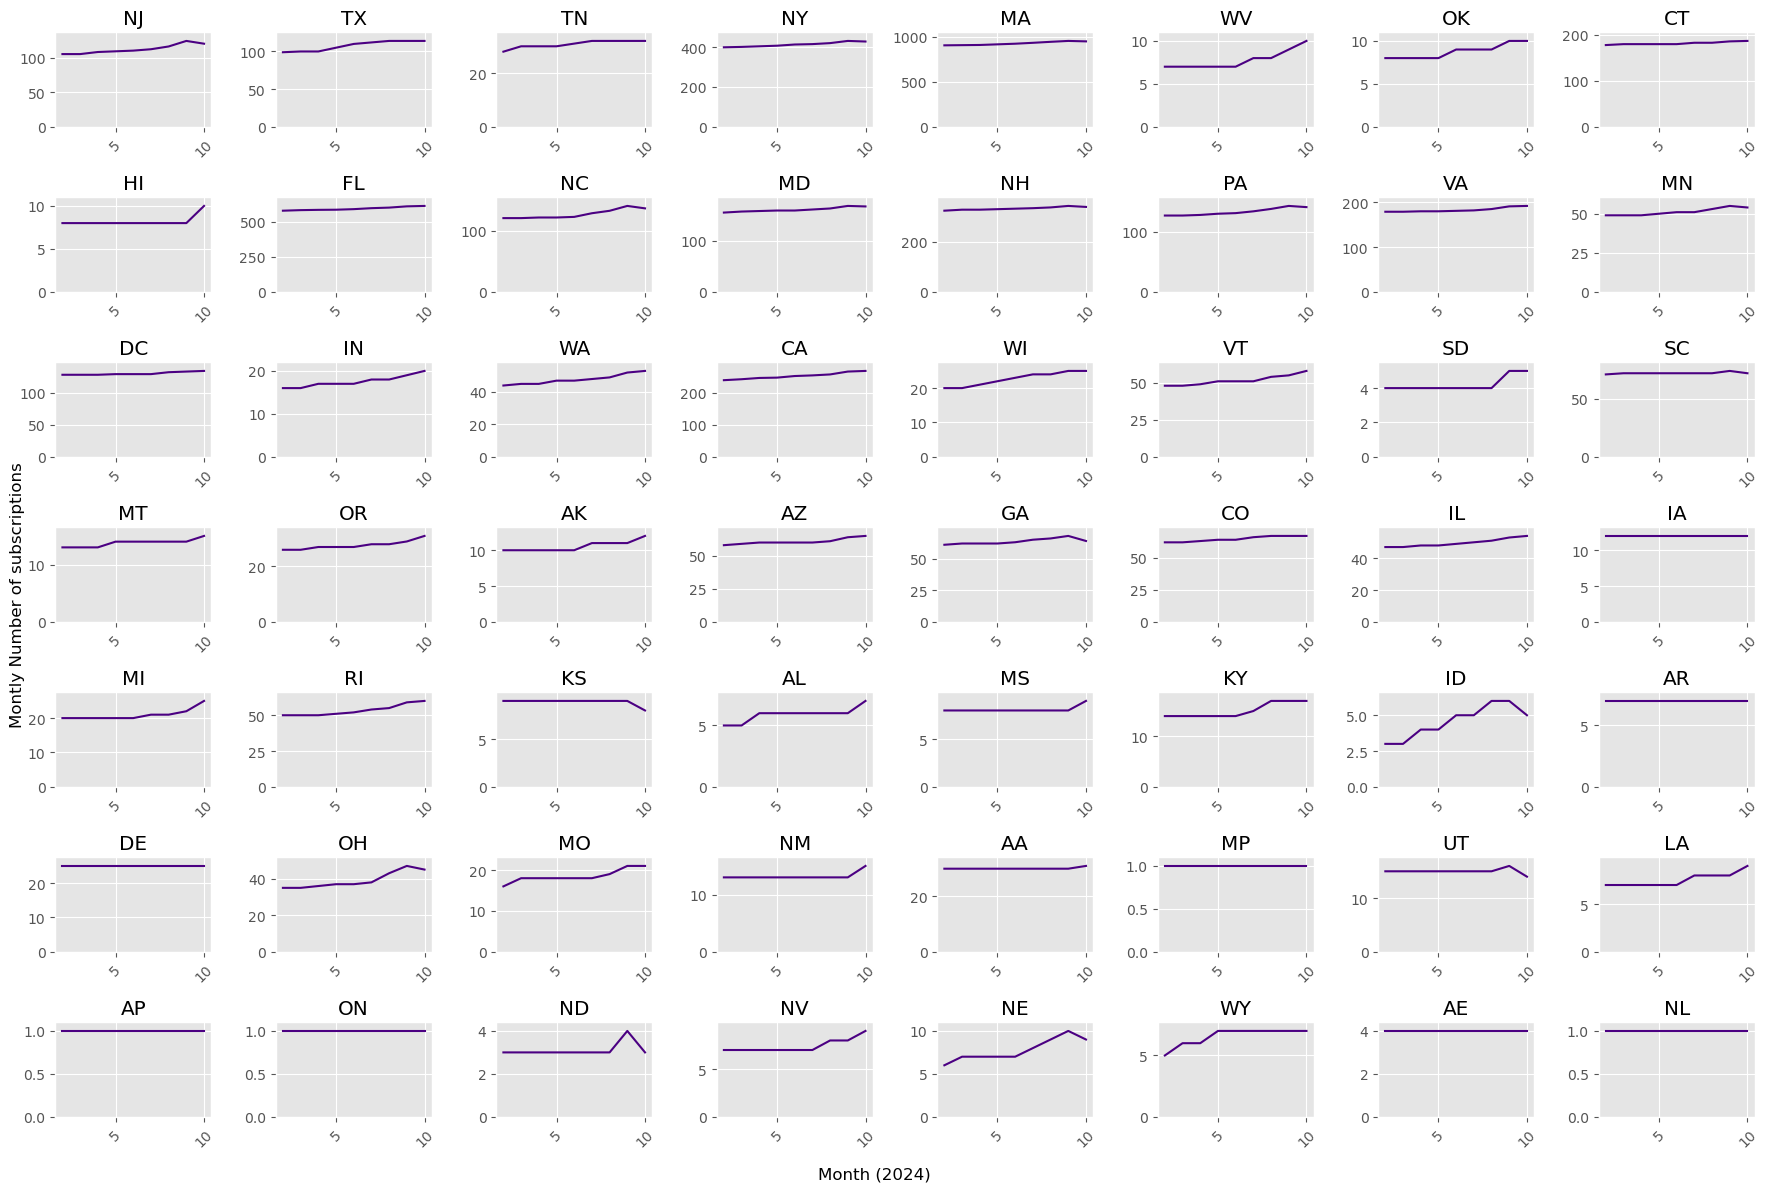

In [13]:
# we can also visualize it all at once! (but w/o PR - sorry!, to make it rectangular)
fig, axs = plt.subplots(7,8,figsize=(18,12))
axs = axs.flatten()

months = range(2,11)

# we're skipping states, so we can't simply use a for loop.
i = 0 # keep track of which axis we're on
j = 0 # keep track of which state we're plotting

while i < 56:
    
    state = state_list[j]
    if state == 'ME' or state == 'PR':
        j += 1
        continue
    ax = axs[i]
    
    state_accs = active_df[active_df.State == state].groupby('Month').count()['AccountID'].rename('Total Accounts').to_numpy()

    ax.plot(months,state_accs,c='indigo')

    # rotate x_axis label
    ax.tick_params(axis='x',labelrotation=45)

    # add title, axis etc
    ax.set(title = state, ylim=(0,state_accs.max()+(.1*state_accs.max())))

    i += 1
    j += 1

fig.supxlabel('Month (2024)')
fig.supylabel('Montly Number of subscriptions')
plt.tight_layout()
# fig.savefig(...,dpi=300) # sure, save it if you really want
plt.show()

### Maine (the actual analysis)
This is what we're actually interested in (we're just very curious people so we had to look at the stuff above!)

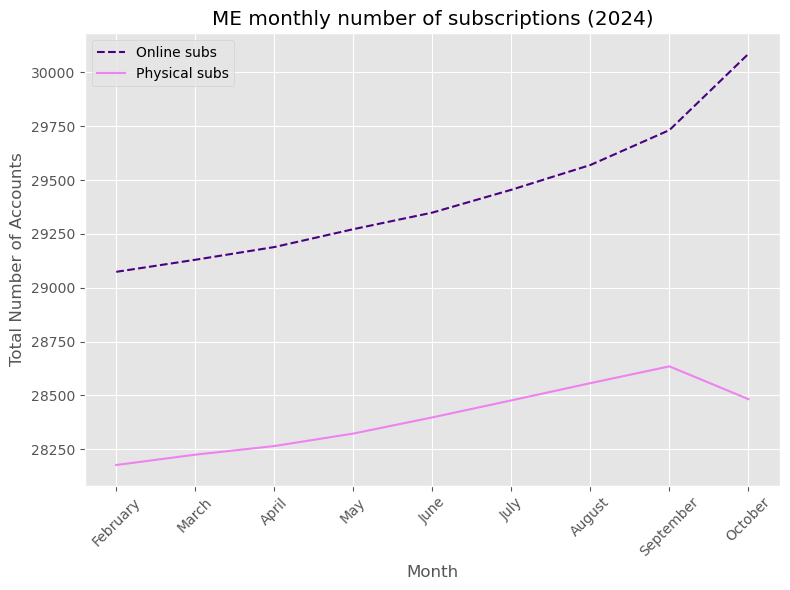

In [14]:
# Since we don't blame you for skipping the sections above,
# here's some code to ensure we have all we need
active_mask = all_data['Status'] == 'Active'
active_df = all_data[active_mask]
months = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']

# Now, let's look at Maine's subscriptions (grouped by Online-vs-Print)
maine_df = active_df[active_df.State=='ME'] 
online_ME = maine_df[maine_df.Online].groupby('Month').count()['AccountID'].rename('Online Accounts').to_numpy()
physical_ME = maine_df[~maine_df.Online].groupby('Month').count()['AccountID'].rename('Physical Accounts').to_numpy()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(months,online_ME,c='indigo',ls='--',label='Online subs')
ax.plot(months,physical_ME,c='violet',label='Physical subs')

# rotate x_axis label
ax.tick_params(axis='x',labelrotation=45)

ax.set(title='ME monthly number of subscriptions (2024)', xlabel='Month', ylabel='Total Number of Accounts')
ax.legend()
plt.tight_layout()

# fig.savefig(...,dpi=300) # save if you want!
plt.show()

#### Cities/Towns with most active accounts

C:\Users\Brandon\AppData\Local\Temp\ipykernel_32572\1112941447.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


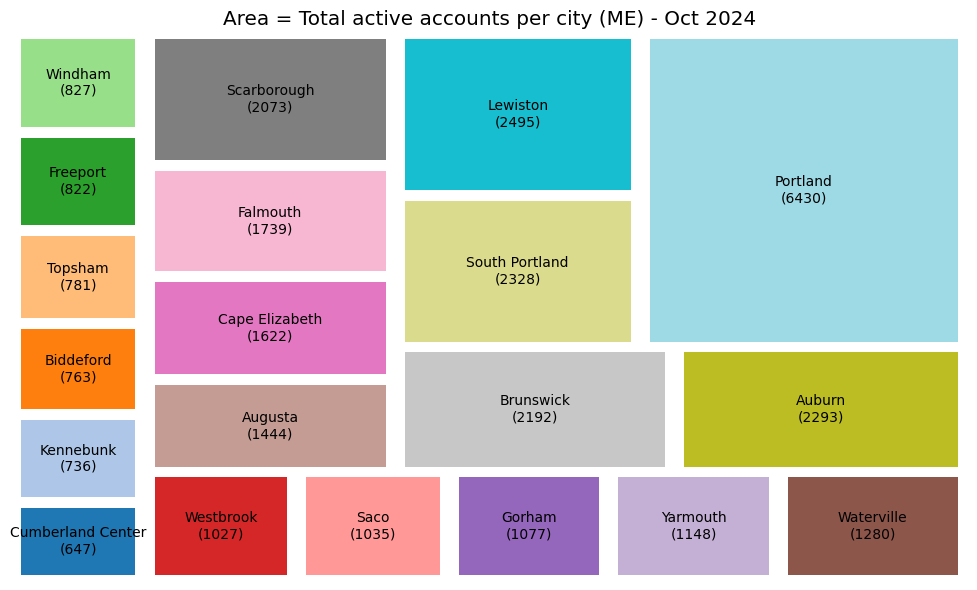

In [15]:
# what are the (20) cities/towns with most subscribers? --> in a Treemap!
ME_counts_df = active_df[np.logical_and(active_df.Month == 10,active_df.State == 'ME')].groupby(['City','Online']).count().AccountID.unstack().rename(columns={False:'Print',True:'Online'})
ME_counts_df['Total'] = ME_counts_df.sum(axis=1)
ME_counts_df = ME_counts_df.sort_values(by='Total', ascending=True)[-20:] # we're looking at the top 20

cmap = cm.get_cmap('tab20')
ME_codes, cities = pd.factorize(ME_counts_df.index)
colors = [cmap(code%20) for code in ME_codes]
labels = ME_counts_df.index+'\n('+ME_counts_df.Total.astype(int).astype(str)+')'

fig, ax = plt.subplots(1,1,figsize=(10,6))

squarify.plot(sizes=ME_counts_df.Total,
              label=labels,
              pad=True,
              color=colors)
plt.axis('off')
ax.set_title('Area = Total active accounts per city (ME) - Oct 2024')
plt.tight_layout()
# fig.savefig(...,dpi=300) # save if you want!
plt.show()

In [16]:
# we can also print the list in order 
print('Top 20 ME cities/towns by total active accounts:\n',maine_df[maine_df.Month==10].groupby('City').count().sort_values(by='AccountID',ascending=False).AccountID.rename('Number of Active Accounts').iloc[:20])

Top 20 ME cities/towns by total active accounts:
 City
Portland             6430
Lewiston             2495
South Portland       2328
Auburn               2293
Brunswick            2192
Scarborough          2073
Falmouth             1739
Cape Elizabeth       1622
Augusta              1444
Waterville           1280
Yarmouth             1148
Gorham               1077
Saco                 1035
Westbrook            1027
Windham               827
Freeport              822
Topsham               781
Biddeford             763
Kennebunk             736
Cumberland Center     647
Name: Number of Active Accounts, dtype: int64


##### including penetration rate
penetration rate = # of subscribers / size of the population

In [17]:
# Now a closer look at the top 10 with penetration rate
# This requires the MainePop.csv data

# get list of top 10
top_10_by_subs = list(maine_df.groupby('City').count().sort_values(by='AccountID',ascending=False).AccountID.iloc[:10].index)

# get population data (we have data for 2020)
pop_data = pd.read_csv('Census_Data/MainePop.csv', usecols=['Place','2020 Total Population'])
pop_data = pop_data.rename(columns={'Place':'City','2020 Total Population':'Population'})
pop_data['City'] = [city.replace(' city','') for city in pop_data.City]
pop_data['City'] = [city.replace(' town','') for city in pop_data.City]

pop_data_sub = pop_data[pop_data.City.isin(top_10_by_subs)] # subset with only the top 10 cities by subscription counts

# now let's merge these two tables and include all useful data
online_df = maine_df[np.logical_and(maine_df.Month==10,maine_df.Online)].groupby('City').count()[['AccountID']].sort_values(by='AccountID',ascending=False)
physical_df = maine_df[np.logical_and(maine_df.Month==10,~maine_df.Online)].groupby('City').count()[['AccountID']].sort_values(by='AccountID',ascending=False)

online_df = online_df[online_df.index.isin(top_10_by_subs)].reindex(top_10_by_subs).rename(columns={'AccountID':'Online'})
physical_df = physical_df[physical_df.index.isin(top_10_by_subs)].reindex(top_10_by_subs).rename(columns={'AccountID':'Print'})

maine_best = online_df.merge(physical_df, left_index=True, right_index=True)
maine_best = maine_best.merge(pop_data_sub, left_index=True, right_on='City')[['City','Population','Print','Online']].reset_index(drop=True)
maine_best['Total'] = maine_best.Print + maine_best.Online
maine_best['Penetration'] = (maine_best.Total / maine_best.Population *100).round(1) # percent penetration rate
print(maine_best)


             City  Population  Print  Online  Total  Penetration
0        Portland       68408   2572    3858   6430          9.4
1        Lewiston       37121   1344    1151   2495          6.7
2  South Portland       26498   1128    1200   2328          8.8
3          Auburn       24061   1055    1238   2293          9.5
4       Brunswick       21756   1189    1003   2192         10.1
5     Scarborough       22135   1177     896   2073          9.4
6        Falmouth       12444    838     901   1739         14.0
7  Cape Elizabeth        9535    681     941   1622         17.0
8         Augusta       18899    802     642   1444          7.6
9      Waterville       15828    583     697   1280          8.1


^ sorted by total number of active accounts.

NOTE: 'Penetration' column is currently formatted as percentages

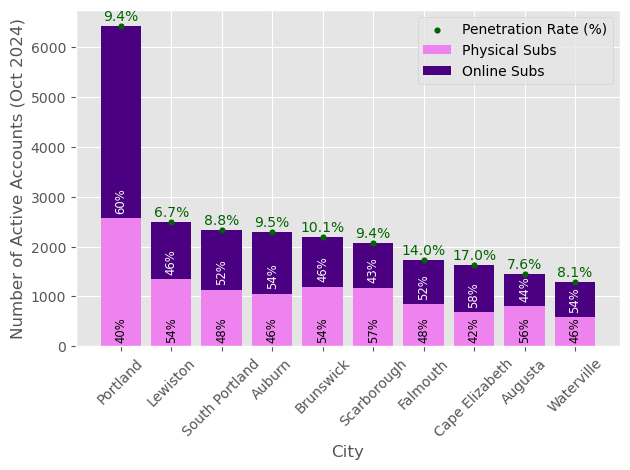

In [18]:
# let's visualize this
fig, ax = plt.subplots()

ax.bar(maine_best.City, maine_best.Print, label='Physical Subs',color='violet')
ax.bar(maine_best.City,maine_best.Online,bottom=maine_best.Print, label='Online Subs', color='indigo')

# add % for bars (as well as penetration on top)
print_percents = (maine_best.Print / maine_best.Total *100).round(0).astype(int)
online_percents = (maine_best.Online / maine_best.Total *100).round(0).astype(int)
for i in range(len(maine_best)):
    # print
    ax.text(maine_best.City[i],70,str(print_percents[i])+'%',ha='center',va='bottom',rotation='vertical',size='small')
    # online
    ax.text(maine_best.City[i],maine_best.Print[i]+100,str(online_percents[i])+'%',ha='center',va='bottom',rotation='vertical',c='white',size='small')
    # penetration rate
    ax.text(maine_best.City[i],maine_best.Total[i]+50,str(maine_best.Penetration[i])+'%',ha='center',va='bottom',color='darkgreen')

# just doing this to add a legend for penetration rates
ax.scatter(maine_best.City,maine_best.Total,c='darkgreen',label='Penetration Rate (%)',s=15)

ax.set(ylabel='Number of Active Accounts (Oct 2024)', xlabel='City')
ax.tick_params(axis='x',labelrotation=45)
ax.legend()
plt.tight_layout()
# fig.savefig(...,dpi=300) # save if you want!
plt.show()

#### Most populated cities/towns in Maine
We know which locations have the most subs. Let's see which locations have the most people to find out what we're missing.

In [19]:
# top 20 cities by population
print(pop_data.sort_values(by='Population', ascending=False)[1:21]) # the data includes ME so we're skipping it

               City  Population
327        Portland       68408
214        Lewiston       37121
24           Bangor       31753
367  South Portland       26498
18           Auburn       24061
36        Biddeford       22552
349     Scarborough       22135
347         Sanford       21982
57        Brunswick       21756
434       Westbrook       20400
346            Saco       20381
19          Augusta       18899
444         Windham       18434
156          Gorham       18336
425      Waterville       15828
457            York       13723
136        Falmouth       12444
202       Kennebunk       11536
429           Wells       11314
297           Orono       11183


C:\Users\Brandon\AppData\Local\Temp\ipykernel_32572\995418368.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


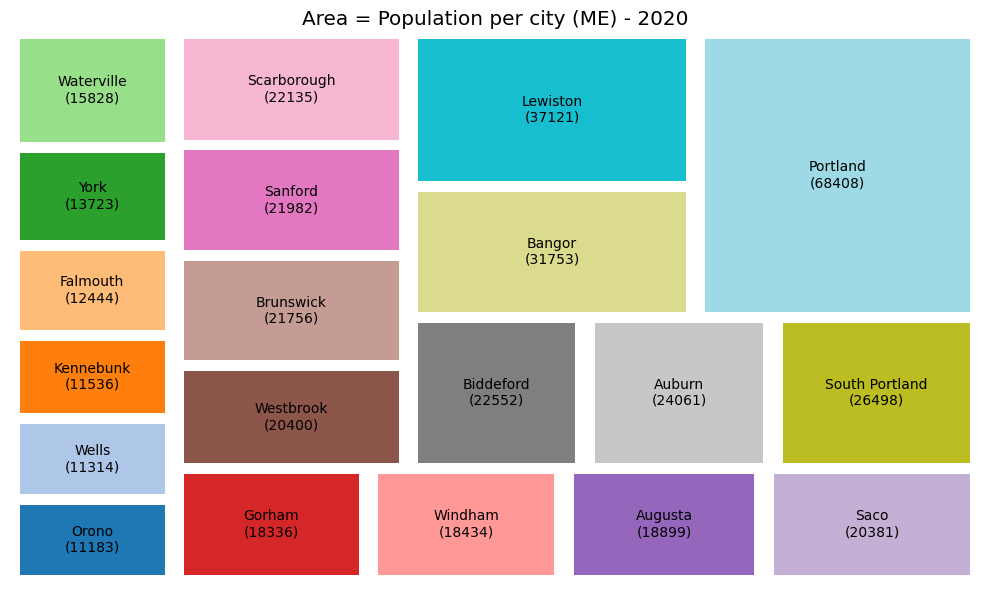

In [20]:
# and of course we can visualize it in a treemap!
pop_df = pop_data.sort_values(by='Population', ascending=True).iloc[-21:-1] # excluding 'Maine'

cmap = cm.get_cmap('tab20')
ME_codes, cities = pd.factorize(pop_df.City)
colors = [cmap(code%20) for code in ME_codes]
labels = pop_df.City+'\n('+pop_df.Population.astype(int).astype(str)+')'

fig, ax = plt.subplots(1,1,figsize=(10,6))

squarify.plot(sizes=pop_df.Population,
              label=labels,
              pad=True,
              color=colors)
plt.axis('off')
ax.set_title('Area = Population per city (ME) - 2020')
plt.tight_layout()
# fig.savefig(...,dpi=300) # save if you want!
plt.show()

Let's look at their penetration rates and other subscription metrics

In [21]:
top_20_by_pop = pop_data.sort_values(by='Population', ascending=False).City.iloc[1:21].values

# and do the same we did to produce the table before
online_df = maine_df[np.logical_and(maine_df.Month==10,maine_df.Online)].groupby('City').count()[['AccountID']].sort_values(by='AccountID',ascending=False)
physical_df = maine_df[np.logical_and(maine_df.Month==10,~maine_df.Online)].groupby('City').count()[['AccountID']].sort_values(by='AccountID',ascending=False)

online_df = online_df[online_df.index.isin(top_20_by_pop)].reindex(top_20_by_pop).rename(columns={'AccountID':'Online'})
physical_df = physical_df[physical_df.index.isin(top_20_by_pop)].reindex(top_20_by_pop).rename(columns={'AccountID':'Print'})

maine_top = online_df.merge(physical_df, left_index=True, right_index=True)
maine_top = maine_top.merge(pop_data, left_index=True, right_on='City')[['City','Population','Print','Online']].reset_index(drop=True)
maine_top['Total'] = maine_top.Print + maine_top.Online
maine_top['Penetration'] = (maine_top.Total / maine_top.Population *100).round(1)
print(maine_top)

              City  Population  Print  Online  Total  Penetration
0         Portland       68408   2572    3858   6430          9.4
1         Lewiston       37121   1344    1151   2495          6.7
2           Bangor       31753     29      97    126          0.4
3   South Portland       26498   1128    1200   2328          8.8
4           Auburn       24061   1055    1238   2293          9.5
5        Biddeford       22552    413     350    763          3.4
6      Scarborough       22135   1177     896   2073          9.4
7          Sanford       21982    242      92    334          1.5
8        Brunswick       21756   1189    1003   2192         10.1
9        Westbrook       20400    568     459   1027          5.0
10            Saco       20381    574     461   1035          5.1
11         Augusta       18899    802     642   1444          7.6
12         Windham       18434    475     352    827          4.5
13          Gorham       18336    588     489   1077          5.9
14      Wa

^ sorted by Population

Notice those with a relatively low penetration rate. Though have in mind that Bangor has a major local newspaper (the *Bangor Daily News*) that is **not** part of the METLN, therefore not really an opportunity market (the same may affect Orono, as one of its neighbors).

Let's look at these more closely (BONUS: THE FOLLOWING PLOT DID NOT MAKE IT TO THE REPORT IN TIME)

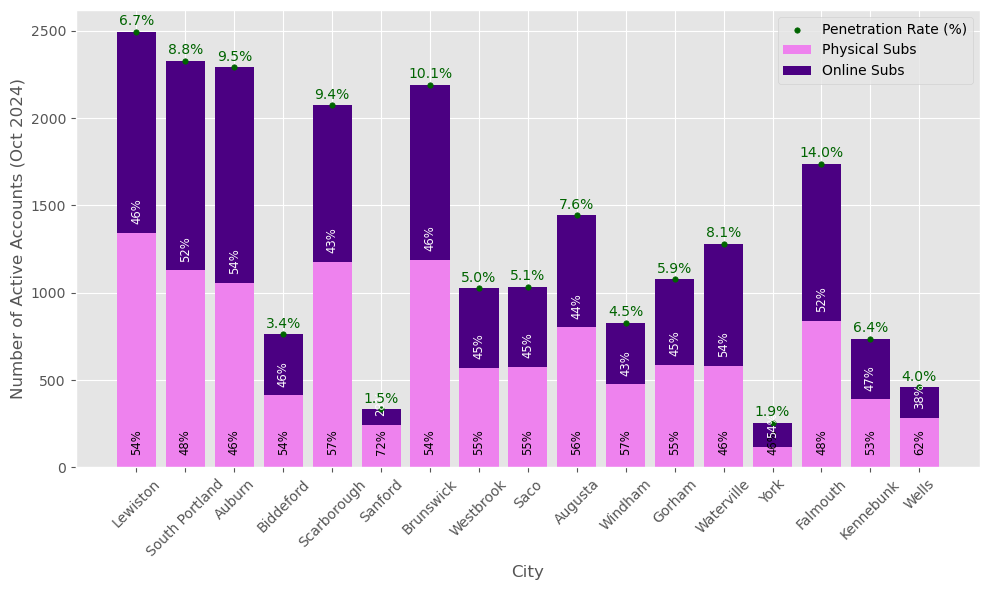

In [22]:
# same as before but now looking at these cities in particular
# and let's exclude Portland (much bigger than the rest)
# as well as Bangor and Orono (might not be applicable to them)

maine_top = maine_top[~maine_top.City.isin(['Portland','Bangor','Orono'])].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(maine_top.City, maine_top.Print, label='Physical Subs',color='violet')
ax.bar(maine_top.City,maine_top.Online,bottom=maine_top.Print, label='Online Subs', color='indigo')

# add % for bars (as well as penetration on top)
print_percents = (maine_top.Print / maine_top.Total *100).round(0).astype(int)
online_percents = (maine_top.Online / maine_top.Total *100).round(0).astype(int)
for i in range(len(maine_top)):
    # print
    ax.text(maine_top.City[i],70,str(print_percents[i])+'%',ha='center',va='bottom',rotation='vertical',size='small')
    # online
    ax.text(maine_top.City[i],maine_top.Print[i]+50,str(online_percents[i])+'%',ha='center',va='bottom',rotation='vertical',c='white',size='small')
    # penetration rate
    ax.text(maine_top.City[i],maine_top.Total[i]+20,str(maine_top.Penetration[i])+'%',ha='center',va='bottom',color='darkgreen')

# just doing this to add a legend for penetration rates
ax.scatter(maine_top.City,maine_top.Total,c='darkgreen',label='Penetration Rate (%)',s=15)

ax.set(ylabel='Number of Active Accounts (Oct 2024)', xlabel='City')
ax.tick_params(axis='x',labelrotation=45)
ax.legend()
plt.tight_layout()
# fig.savefig(...,dpi=300) # save if you want!
plt.show()

We see Biddeford, Sanford, and York (all in York County) as particularly interesting opportunity markets.